# Plateforme de recommandation des produits Chanel

On commence par importer les modules nécessaires :

In [68]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests
from PIL import Image
from io import BytesIO

## Partie 1 : Analyse approfondie du jeu de données

### 1. Exploration initiale

On charge les données :

In [69]:
data = pd.read_parquet('data.parquet')

On prend connaissance des dimensions du dataset :

In [70]:
data.shape

(1428, 17)

On prend aussi connaissance du type de chaque colonne :

In [71]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1428 entries, 0 to 1427
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   website_name     1428 non-null   object 
 1   competence_date  1428 non-null   object 
 2   country_code     1428 non-null   object 
 3   currency_code    1428 non-null   object 
 4   brand            1428 non-null   object 
 5   category1_code   1428 non-null   object 
 6   category2_code   1428 non-null   object 
 7   category3_code   1428 non-null   object 
 8   product_code     1428 non-null   object 
 9   title            1428 non-null   object 
 10  itemurl          1428 non-null   object 
 11  imageurl         1428 non-null   object 
 12  full_price       1428 non-null   float64
 13  price            1428 non-null   float64
 14  full_price_eur   1428 non-null   float64
 15  price_eur        1428 non-null   float64
 16  flg_discount     1428 non-null   int64  
dtypes: float64(4),

On vérifie s'il y a des valeurs nulles :

In [72]:
data.isna().sum()

website_name       0
competence_date    0
country_code       0
currency_code      0
brand              0
category1_code     0
category2_code     0
category3_code     0
product_code       0
title              0
itemurl            0
imageurl           0
full_price         0
price              0
full_price_eur     0
price_eur          0
flg_discount       0
dtype: int64

En l'occurence, ce dataset ne comporte pas de valeurs nulles.

Voici un aperçu des 5 premières lignes du dataset :

In [73]:
data.head()

,website_name,competence_date,country_code,currency_code,brand,category1_code,category2_code,category3_code,product_code,title,itemurl,imageurl,full_price,price,full_price_eur,price_eur,flg_discount
0,Chanel,2023-11-17,DEU,EUR,CHANEL,FASHION,HANDBAGS,N.A.,PAS4152B13455,Tweed & goldfarbenes Metall Schwarz Rosa & B...,https://www.chanel.com/de/mode/p/AS4152B13455N...,https://res.cloudinary.com/dwayrkp5z/image/fet...,5200.0,5200.0,5200.0,5200.0,0
1,Chanel,2023-11-17,DEU,EUR,CHANEL,FASHION,HANDBAGS,N.A.,PA67085Y09953,n.a.,https://www.chanel.com/de/mode/p/A67085Y099539...,https://res.cloudinary.com/dwayrkp5z/image/fet...,5750.0,5750.0,5750.0,5750.0,0
2,Chanel,2023-11-17,DEU,EUR,CHANEL,EYEWEAR,BLUE LIGHT GLASSES,N.A.,PA71441,Schwarz,https://www.chanel.com/de/brillen/p/A71441X081...,https://res.cloudinary.com/dwayrkp5z/image/fet...,420.0,420.0,420.0,420.0,0
3,Chanel,2023-11-17,DEU,EUR,CHANEL,EYEWEAR,SUNGLASSES,N.A.,PA71449,Silberfarben. Gläser: Braun Mit Verlauf,https://www.chanel.com/de/brillen/p/A71449X099...,https://res.cloudinary.com/dwayrkp5z/image/fet...,580.0,580.0,580.0,580.0,0
4,Chanel,2023-11-17,DEU,EUR,CHANEL,EYEWEAR,SUNGLASSES,N.A.,PA71466,Blau & Rosa. Gläser: Grau Mit Verlauf,https://www.chanel.com/de/brillen/p/A71466X010...,https://res.cloudinary.com/dwayrkp5z/image/fet...,480.0,480.0,480.0,480.0,0


On remarque que certaines colonnes ont l'air d'avoir une seule valeur pour toutes les entrées, on y remédiera dans la prochaine sous-section.

On recueilles les statistiques sur les données quantitatives :

In [74]:
data.describe()

,full_price,price,full_price_eur,price_eur,flg_discount
count,1428.000000,1428.000000,1428.000000,1428.000000,1428.0
mean,6076.253725,6076.253725,6076.253725,6076.253725,0.0
std,15219.005999,15219.005999,15219.005999,15219.005999,0.0
min,23.000000,23.000000,23.000000,23.000000,0.0
25%,195.000000,195.000000,195.000000,195.000000,0.0
50%,1415.000000,1415.000000,1415.000000,1415.000000,0.0
75%,5800.000000,5800.000000,5800.000000,5800.000000,0.0
max,142000.000000,142000.000000,142000.000000,142000.000000,0.0


On remarque que ces colonnes présentent les mêmes statistiques, il est possible que ces quatres colonnes comportent les mêmes valeurs pour chaque entrée. On vérifie cela :

In [75]:
colonnes = ['full_price', 'price', 'full_price_eur', 'price_eur']
(data[colonnes].nunique(axis=1)==1).all()

True

Ces quatres colonnes sont effectivement identiques.

On écrit une fonction pour analyser la qualité et la diversité des images (dimensions, couleurs, formats) :

In [76]:
def analyze_image_quality(df, sample_size=50):
    print(f"Analyse de {sample_size} images aléatoires :")
    sample = df.sample(sample_size, random_state=42)
    widths = []
    heights = []
    modes = []
    
    for _, row in sample.iterrows():
        try:
            response = requests.get(row['imageurl'], timeout=3)
            img = Image.open(BytesIO(response.content))
            w, h = img.size
            widths.append(w)
            heights.append(h)
            modes.append(img.mode)
        except Exception as e:
            print(f"Erreur de chargement pour {row['product_code']}")

    # Visualisation des dimensions
    plt.figure(figsize=(10, 5))
    plt.scatter(widths, heights, alpha=0.6, c='blue')
    plt.title(f"Dimensions des images (Echantillon n={sample_size})")
    plt.xlabel("Largeur (px)")
    plt.ylabel("Hauteur (px)")
    plt.show()
    
    print(f"Dimensions uniques trouvées : {set(zip(widths, heights))}")
    print(f"Modes de couleurs trouvés : {set(modes)}")

On lance l'analyse :

Analyse de 50 images aléatoires :
Erreur de chargement pour PJ12307
Erreur de chargement pour PAP3604B14342
Erreur de chargement pour PJ12118
Erreur de chargement pour PP140730
Erreur de chargement pour PAP0953B04852
Erreur de chargement pour PPH6593
Erreur de chargement pour PJ12157
Erreur de chargement pour PP140680
Erreur de chargement pour PPH7609
Erreur de chargement pour PP120900
Erreur de chargement pour PP143030
Erreur de chargement pour PP107809
Erreur de chargement pour PJ12071
Erreur de chargement pour PP102940
Erreur de chargement pour PJ12091
Erreur de chargement pour PP102440
Erreur de chargement pour PA92193Y09953
Erreur de chargement pour PA71547
Erreur de chargement pour PP144260
Erreur de chargement pour PP126300
Erreur de chargement pour PG31318Y50006
Erreur de chargement pour PA75272
Erreur de chargement pour PP147540


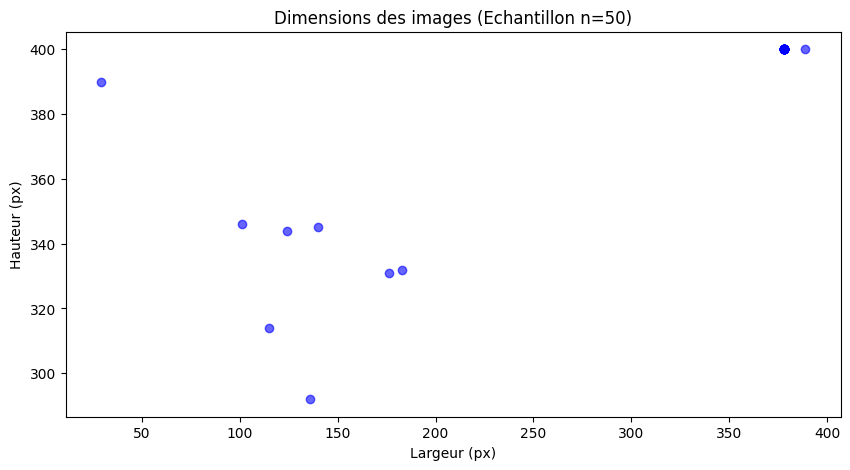

Dimensions uniques trouvées : {(183, 332), (140, 345), (176, 331), (124, 344), (115, 314), (136, 292), (378, 400), (389, 400), (101, 346), (29, 390)}
Modes de couleurs trouvés : {'RGB', 'P'}


In [77]:
analyze_image_quality(data, sample_size=50)

On remarque qu'on a des erreurs de chargement sur certaines images. En fait, ces images ne sont pas accessibles.

Aussi, les images ont des tailles très variées et des rations différents. Il faudra sûrement implémenter une étape de redimensionnement et probablement de padding pour ne pas déformer les images tout en les adaptant à un format convenable pour certains modèles de deep learning (comme ResNet ou les CNN).

Enfin, il y a des images en RGB, mais il y en a aussi en P (Palette). Il faudra convertir ces dernières en RGB pour les modèles de vision.

### 2. Préparation des données

On supprime les colonnes pour lesquelles la même valeur est présente pour toutes les entrées :

In [78]:
for colonne in data.columns:
    if data[colonne].nunique() == 1 :
        data.drop(colonne, axis = 1, inplace = True)
        print("La colonne " + colonne + "a été supprimée")

La colonne website_namea été supprimée
La colonne competence_datea été supprimée
La colonne country_codea été supprimée
La colonne currency_codea été supprimée
La colonne branda été supprimée
La colonne category3_codea été supprimée
La colonne flg_discounta été supprimée


On ne garde aussi qu'une seule colonne parmi `full_price`, `price`, `full_price_eur`, et `price_eur` puisqu'elles sont identiques :

In [79]:
colonnes = ['full_price','full_price_eur', 'price_eur']
data.drop(colonnes, axis=1, inplace=True)

Voici un aperçu du dataframe nettoyé :

In [80]:
data.head()

,category1_code,category2_code,product_code,title,itemurl,imageurl,price
0,FASHION,HANDBAGS,PAS4152B13455,Tweed & goldfarbenes Metall Schwarz Rosa & B...,https://www.chanel.com/de/mode/p/AS4152B13455N...,https://res.cloudinary.com/dwayrkp5z/image/fet...,5200.0
1,FASHION,HANDBAGS,PA67085Y09953,n.a.,https://www.chanel.com/de/mode/p/A67085Y099539...,https://res.cloudinary.com/dwayrkp5z/image/fet...,5750.0
2,EYEWEAR,BLUE LIGHT GLASSES,PA71441,Schwarz,https://www.chanel.com/de/brillen/p/A71441X081...,https://res.cloudinary.com/dwayrkp5z/image/fet...,420.0
3,EYEWEAR,SUNGLASSES,PA71449,Silberfarben. Gläser: Braun Mit Verlauf,https://www.chanel.com/de/brillen/p/A71449X099...,https://res.cloudinary.com/dwayrkp5z/image/fet...,580.0
4,EYEWEAR,SUNGLASSES,PA71466,Blau & Rosa. Gläser: Grau Mit Verlauf,https://www.chanel.com/de/brillen/p/A71466X010...,https://res.cloudinary.com/dwayrkp5z/image/fet...,480.0


### 3. Visualisation

On représente la distribution des catégories :

<Axes: ylabel='count'>

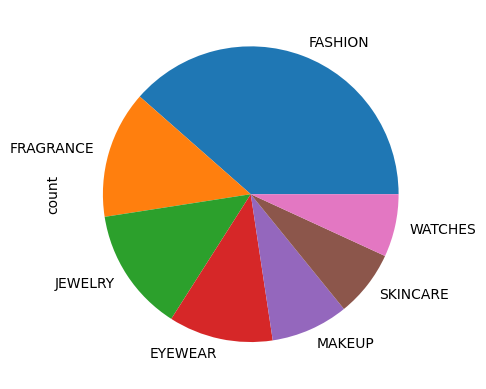

In [81]:
data.category1_code.value_counts().plot.pie()

In [82]:
data.category2_code.value_counts()

category2_code
READY-TO-WEAR                  243
COSTUME JEWELRY                127
SUNGLASSES                      99
WOMEN                           88
WATCHES                         87
MEN                             72
HANDBAGS                        61
COCO CRUSH                      54
SHOES                           42
FACE                            41
EYEGLASSES                      40
SMALL LEATHER GOODS             38
BATH AND BODY                   36
MOISTURIZERS                    35
EYES                            35
RINGS                           35
NECKLACES                       30
BRUSHES AND ACCESSORIES         26
EARRINGS                        26
BLUE LIGHT GLASSES              24
LIPS                            21
N°5                             15
TONERS & LOTIONS                11
EXCEPTIONAL PIECES              11
CLEANSERS & MAKEUP REMOVERS     11
BELTS                           10
HEADWEAR                         9
OILS                             9
BRACE

/var/folders/zv/2djxbbx13ysbr2pfl27pgp680000gn/T/ipykernel_18611/665404679.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cats.values, y=top_cats.index, palette='viridis')


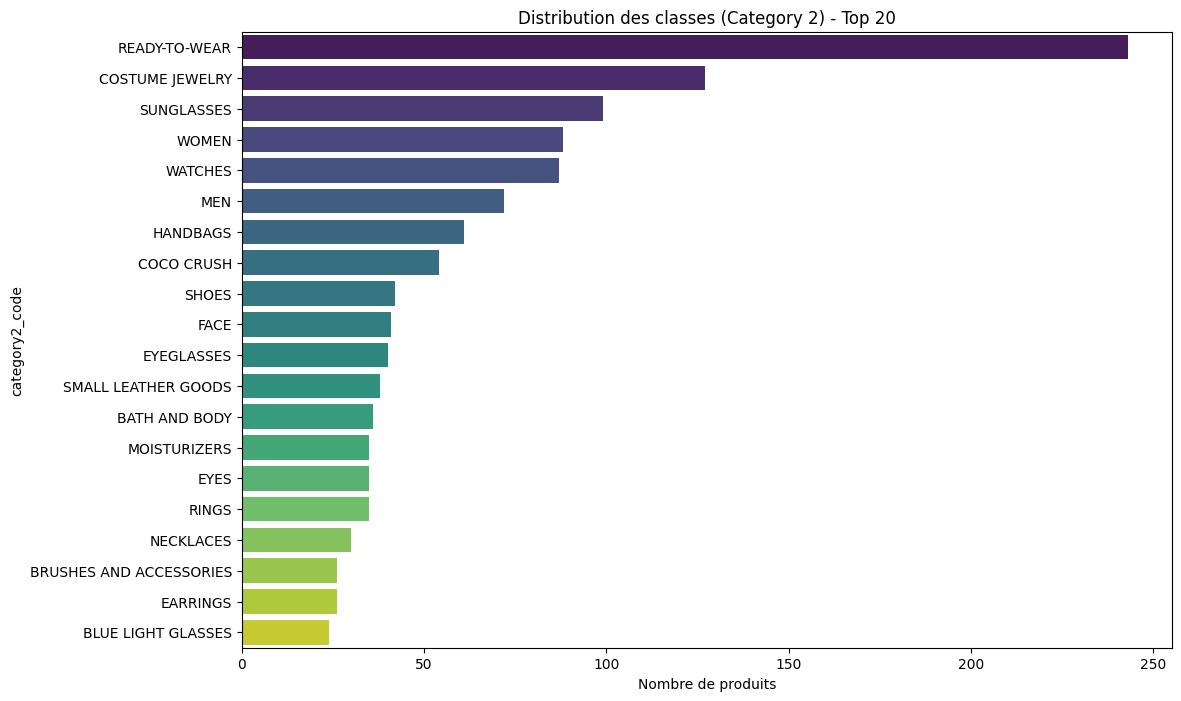

La classe majoritaire (READY-TO-WEAR) représente 17.0% du dataset.


In [83]:
plt.figure(figsize=(12, 8))
# On affiche le Top 20 des catégories pour la lisibilité
top_cats = data['category2_code'].value_counts().nlargest(20)
sns.barplot(x=top_cats.values, y=top_cats.index, palette='viridis')
plt.title('Distribution des classes (Category 2) - Top 20')
plt.xlabel('Nombre de produits')
plt.show()

# Analyse du biais
print(f"La classe majoritaire ({top_cats.index[0]}) représente {top_cats.iloc[0]/len(data):.1%} du dataset.")

On remarque que la distribution de `category2_code` est très hétérogène.

On représente la distribution des prix :

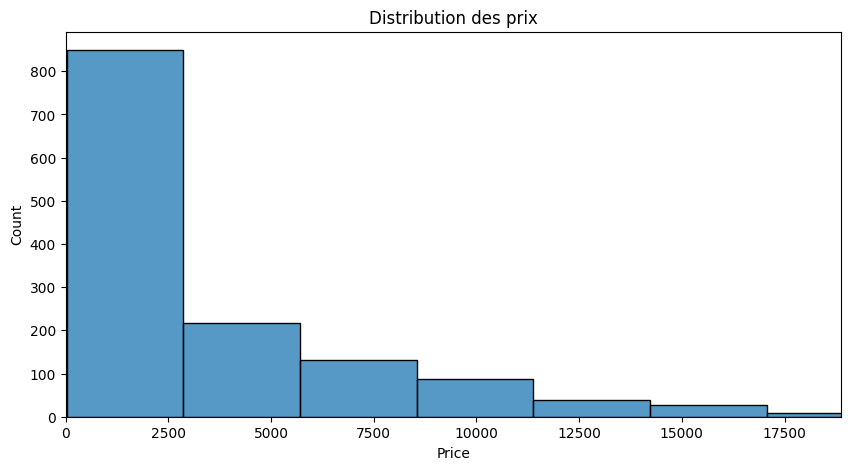

In [84]:
plt.figure(figsize=(10, 5))
sns.histplot(data['price'], bins=50)
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Distribution des prix')
plt.xlim(0, data['price'].quantile(0.95)) # On coupe les valeurs extrêmes pour y voir clair
plt.show()

Voici les cinq produits les plus chers :

In [85]:
data.nlargest(5,'price')

,category1_code,category2_code,product_code,title,itemurl,imageurl,price
1216,JEWELRY,RINGS,PJ63142,18 Karat Weißgold Diamanten schwarze Spinelle,https://www.chanel.com/de/schmuck/p/J63142/com...,https://res.cloudinary.com/dwayrkp5z/image/fet...,142000.0
790,JEWELRY,LES INTEMPORELS DE CHANEL,PJ60909,18 Karat Weißgold Diamanten,https://www.chanel.com/de/schmuck/p/J60909/rub...,https://res.cloudinary.com/dwayrkp5z/image/fet...,132000.0
1332,WATCHES,EXCEPTIONAL PIECES,PPH7431,Extrem widerstandsfähige weiße Keramik und Wei...,https://www.chanel.com/de/uhren/p/H7431/j12-ba...,https://res.cloudinary.com/dwayrkp5z/image/fet...,130000.0
788,JEWELRY,BRACELETS,PJ2831,18 Karat Weißgold Diamanten,https://www.chanel.com/de/schmuck/p/J2831/come...,https://res.cloudinary.com/dwayrkp5z/image/fet...,123000.0
437,WATCHES,EXCEPTIONAL PIECES,PPH6949,Großes Modell BEIGEGOLD und Diamanten goldbr...,https://www.chanel.com/de/uhren/p/H6949/boy-fr...,https://res.cloudinary.com/dwayrkp5z/image/fet...,120000.0


On représente les longueurs des titres :

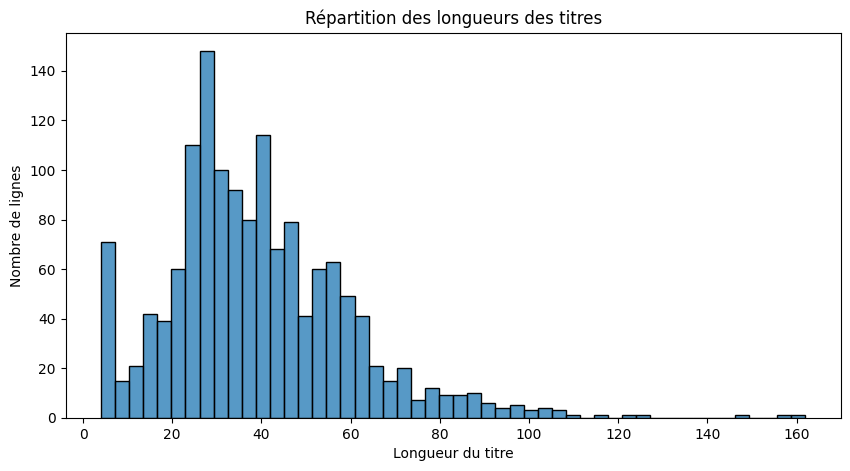

In [86]:
plt.figure(figsize=(10,5))
sns.histplot(data['title'].str.len(), bins=50)
plt.xlabel('Longueur du titre')
plt.ylabel('Nombre de lignes')
plt.title('Répartition des longueurs des titres')
plt.show()

On nettoie les titres en mettant tout en minuscule et en supprimant les espaces avant/après :

In [87]:
data['clean_title'] = data['title'].str.lower().str.strip()

On vérifie la présence de doublons dans les titres :

In [88]:
duplicates = data[data.duplicated(subset=['clean_title'], keep=False)]
print(f"Nombre de titres dupliqués : {len(duplicates)}")
print(f"Proportion de titres dupliqués : {len(duplicates)/len(data['title']):.2%}")

Nombre de titres dupliqués : 806
Proportion de titres dupliqués : 56.44%


Il y a 56.44 % de titres dupliqués. C'est un chiffre très élevé. Cela signifie que notre modèle textuel aura beaucoup de mal à distinguer les produits. Si l'utilisateur tape un titre, le système textuel verra 50 articles identiques. Le texte seul est donc insuffisant pour discriminer les produits, l'image (qui montre la couleur spécifique) sera donc nécessaire.

On visualise les tittres nettoyés :

In [89]:
display(data[['title', 'clean_title']].head())

,title,clean_title
0,Tweed & goldfarbenes Metall Schwarz Rosa & B...,tweed & goldfarbenes metall schwarz rosa & b...
1,n.a.,n.a.
2,Schwarz,schwarz
3,Silberfarben. Gläser: Braun Mit Verlauf,silberfarben. gläser: braun mit verlauf
4,Blau & Rosa. Gläser: Grau Mit Verlauf,blau & rosa. gläser: grau mit verlauf


On écrit une fonction pour afficher cinq exemples de produits pour les trois catégories les plus fréquentes :

In [90]:
def show_category_examples(df, category_col='category2_code', n_examples=5):
    top_categories = df[category_col].value_counts().head(3).index.tolist()
    
    for cat in top_categories:
        print(f"Catégorie : {cat}")
        subset = df[df[category_col] == cat].sample(n_examples)
        
        plt.figure(figsize=(15, 5))
        for i, (_, row) in enumerate(subset.iterrows()):
            try:
                response = requests.get(row['imageurl'], timeout=3)
                img = Image.open(BytesIO(response.content))
                
                plt.subplot(1, n_examples, i+1)
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"{row['price']}€", fontsize=10)
            except:
                pass
        plt.show()

On exécute cette fonction d'affichage :

Catégorie : READY-TO-WEAR


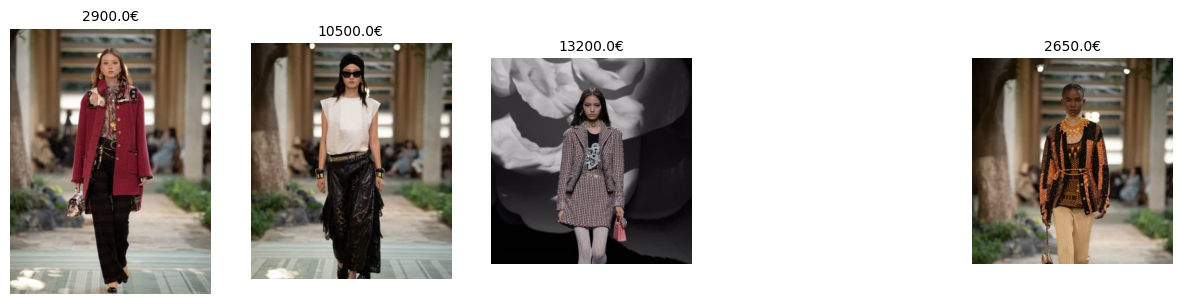

Catégorie : COSTUME JEWELRY


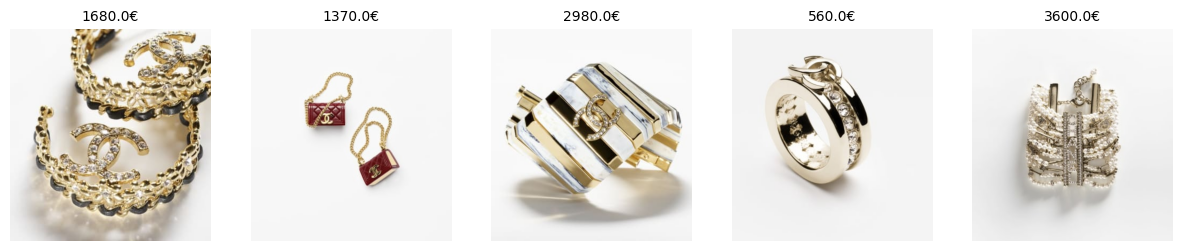

Catégorie : SUNGLASSES


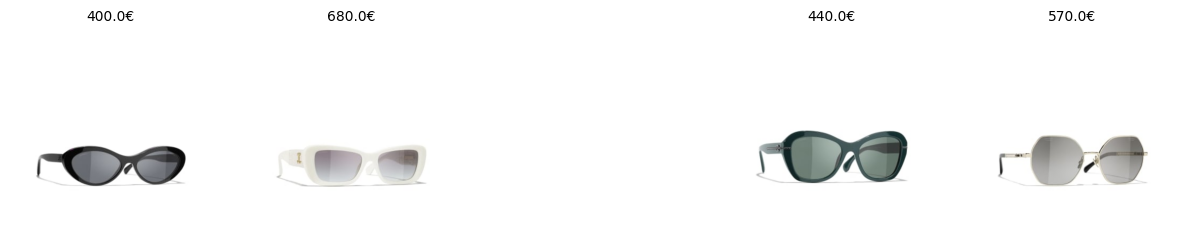

In [91]:
show_category_examples(data)

On note que les correspondances entre les images, les descriptions et les catégories sont cohérentes.

On représente la distribution des prix par catégorie  sous la forme d'une boîte à moustache :

/var/folders/zv/2djxbbx13ysbr2pfl27pgp680000gn/T/ipykernel_18611/4028035275.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_filtered, x='price', y='category2_code', palette="viridis")


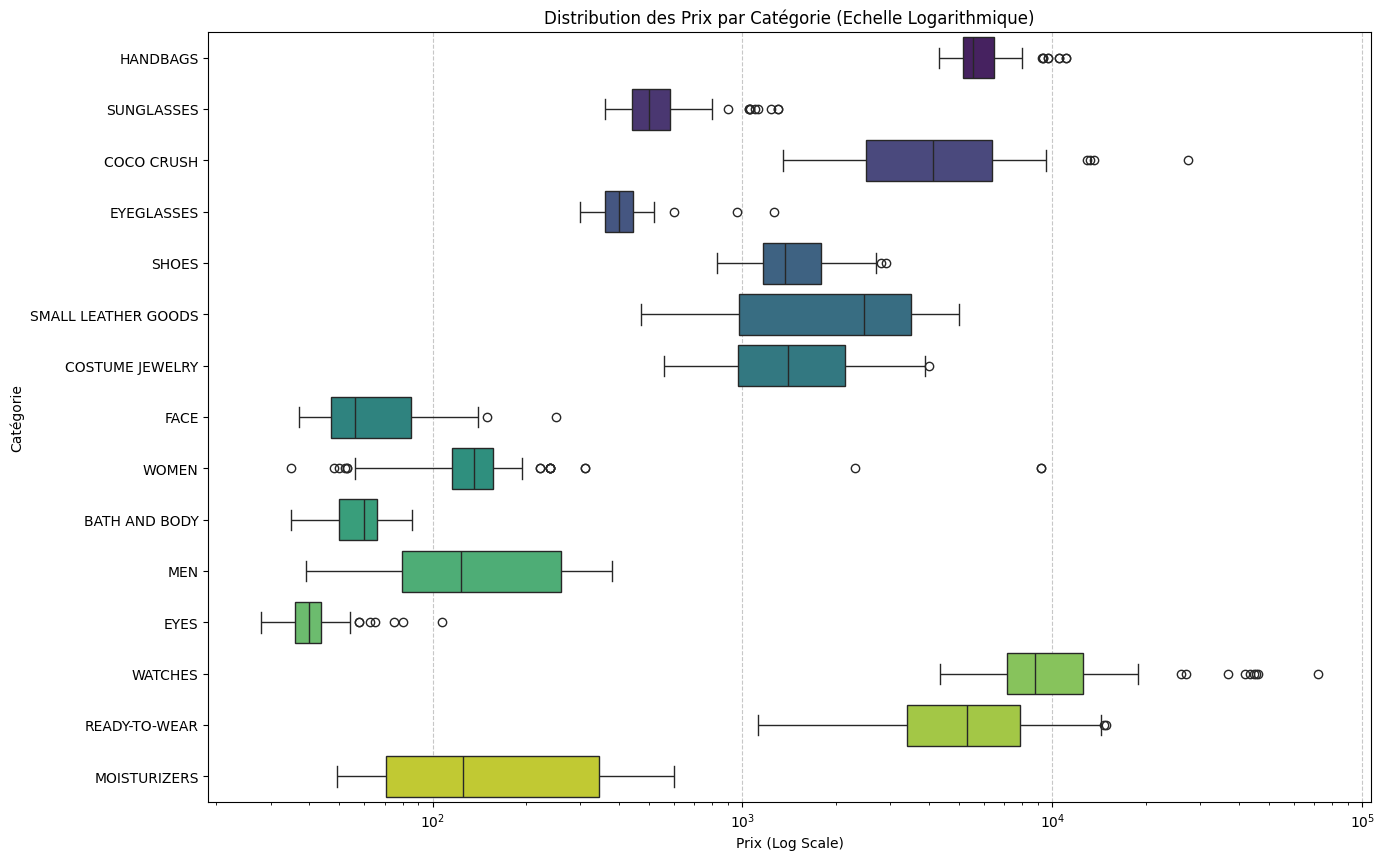

In [92]:
# Configuration de la taille
plt.figure(figsize=(15, 10))

# On ne garde que les catégories avec assez de produits pour que le graph soit lisible
top_cats_list = data['category2_code'].value_counts().nlargest(15).index
data_filtered = data[data['category2_code'].isin(top_cats_list)]

# Création du Boxplot
sns.boxplot(data=data_filtered, x='price', y='category2_code', palette="viridis")

# Affichage en échelle logarithmique
plt.xscale('log') 
plt.title('Distribution des Prix par Catégorie (Echelle Logarithmique)')
plt.xlabel('Prix (Log Scale)')
plt.ylabel('Catégorie')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.show()

On remarque que les montres représentent la catégorie avec la plus grande dispersion. Cela montre que Chanl vend à la fois des montres abordables et des pièces de haute horlogerie. Concernant les sacs, la médiane de cette catégorie est très élevée, cela signifie qu'il n'y a pas de sac "pas cher" chez Chanel.

En tout cas, cette visualisation met en évidence une segmentation tarifaire en trois tiers : les cosmétiques (entrée de gamme), les accessoires de mode (milieu de gamme), et les pièces de haute valeur (haut de gamme).

## Partie 2 : Comparaison des embeddings visuels

### 1. Méthodes pour extraire les embeddings visuels

#### Méthode 1 : Modèle entraîné pour la classification

#### Méthode 2 : Utilisation d’un modèle pré-entraîné

#### Méthode 3 : Self-supervised learning

### 2. Comparaison des trois méthodes

## Partie 3 : Analyse et comparaison des embeddings textuels

### 1. Traduction des descriptions

In [93]:
import requests
import os
from tqdm import tqdm

API_KEY = "0f6b7853-5567-4c01-a117-98b90787e917:fx"
DEEPL_URL = "https://api-free.deepl.com/v2/translate"

# Fonction de traduction avec DeepL
def deepl_translate(text):
    payload = {
        "auth_key": API_KEY,
        "text": text,
        "source_lang": "DE",
        "target_lang": "EN"
    }
    response = requests.post(DEEPL_URL, data=payload)
    return response.json()["translations"][0]["text"]


# Traduction des titres en anglais si le fichier n'existe pas déjà
if not os.path.exists('titles_en.csv'):
    english_titles = []
    for title in tqdm(data["title"]):
        try:
            english_titles.append(deepl_translate(title))
        except:
            english_titles.append("")

    data["english_title"] = english_titles
    
    # Sauvegarder les titres traduits
    pd.DataFrame({'english_title': english_titles}).to_csv('titles_en.csv', index=False)
    print("Titres traduits et sauvegardés dans 'titles_en.csv'")
else:
    # Charger les titres depuis le fichier CSV
    data["english_title"] = pd.read_csv('titles_en.csv')['english_title']
    print("Titres chargés depuis 'titles_en.csv'")

Titres chargés depuis 'titles_en.csv'


Ce code traduit automatiquement les titres des produits du dataset vers l’anglais en utilisant l’API DeepL, puis enregistre les traductions dans un fichier titles_en.csv (ou les recharge si le fichier existe déjà) afin d’éviter de répéter les appels API

In [94]:
# affichage aleatoire de 10 titres traduits
import random
for i in random.sample(range(len(data)), 10):
    print(f"DE: {data.iloc[i]['title']}")
    print(f"EN: {data.iloc[i]['english_title']}")
    print()

DE: 18 Karat Weißgold  Diamanten  schwarze Spinelle
EN: 18 carat white gold diamonds black spinels

DE: 18 Karat Weißgold  Diamanten
EN: 18 carat white gold diamonds

DE: 18 Karat Weißgold  Diamanten
EN: 18 carat white gold diamonds

DE: Samt  Schwarz & silberfarben
EN: Velvet black & silver

DE: SEIFE
EN: SEIFE

DE: Graues Schildpatt. Gläser: Grau  Mit Verlauf
EN: Gray tortoiseshell. Lenses: Grey with gradient

DE: HIGHLIGHTER-PUDER MAXI-FORMAT
EN: HIGHLIGHTER POWDER MAXI FORMAT

DE: n.a.
EN: n.a.

DE: DEODORANT STICK
EN: DEODORANT STICK

DE: ESSENCE TWIST AND SPRAY
EN: ESSENCE TWIST AND SPRAY



On remarque que la traduction a bien marché

### 2. Génération des embeddings textuels

In [95]:
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm
import numpy as np

# Charger le modèle MiniLM (Sentence-BERT) via Transformers
model_name = "sentence-transformers/all-MiniLM-L6-v2"
print("Chargement de MiniLM (Sentence-BERT) via Transformers")

# Charger le tokenizer et le modèle
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Définir le périphérique
device = torch.device("cpu")  
model.to(device)

# Fonction de mean pooling
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    mask = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * mask, dim=1) / torch.clamp(mask.sum(dim=1), min=1e-9)

# Fonction pour encoder les textes par batch
def encode_texts(texts, batch_size=32):
    all_embeddings = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i : i + batch_size]

        encoded = tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True
        ).to(device)

        with torch.no_grad():
            output = model(**encoded)

        embeddings = mean_pooling(output, encoded["attention_mask"])
        embeddings = embeddings.cpu().numpy()

        all_embeddings.append(embeddings)

        # Force cleanup
        del encoded, output
        torch.cuda.empty_cache() if device.type == "cuda" else None

    return np.vstack(all_embeddings)


# Extraire les titres en anglais
titles_en = data["english_title"].tolist()

# Encoder les embeddings avec Sentence-BERT
print("Encodage des embeddings Sentence-BERT")
embeddings_sbert = encode_texts(titles_en, batch_size=32)

# sauvegarder comme un tableau NumPy séparé pour récupération ultérieure
data["embedding_sbert"] = list(embeddings_sbert)

embeddings_sbert.shape


Chargement de MiniLM (Sentence-BERT) via Transformers
Encodage des embeddings Sentence-BERT


100%|██████████| 45/45 [00:00<00:00, 45.51it/s]


(1428, 384)

### 3. Analyse des embeddings

In [96]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Charger les embeddings depuis le fichier si la colonne n'existe pas déjà dans data
if 'embedding_sbert' not in data.columns:
    embeddings_sbert = np.load("embeddings_sbert.npy")
    data["embedding_sbert"] = list(embeddings_sbert)
    print(f"✅ Embeddings chargés depuis le fichier : shape = {embeddings_sbert.shape}")

# Martrice des embeddings (N x D)
X = np.vstack(data["embedding_sbert"].values)

# Matrice de similarité cosinus (N x N)
similarity_matrix = cosine_similarity(X)

print(f"Matrice de similarité créée : shape = {similarity_matrix.shape}")

Matrice de similarité créée : shape = (1428, 1428)


In [97]:
# Charger les titres en anglais et les fusionner avec le dataframe
titles_en = pd.read_csv("titles_en.csv")
data = data.reset_index(drop=True)
data["english_title"] = titles_en["english_title"]
print(f"Titres en anglais ajoutés : {len(data)} lignes")

Titres en anglais ajoutés : 1428 lignes


In [98]:
# Choisir un produit de requête

idx = data[data["english_title"].str.contains("Perfume", case=False)].index[0]
query_title = data.loc[idx, "english_title"]

print("Produit choisi :", query_title)


Produit choisi : PERFUME POCKET ATOMIZER


In [99]:
# On trie par similarité décroissante
similar_indices = similarity_matrix[idx].argsort()[::-1]

print("\n PRODUITS LES PLUS SIMILAIRES TEXTUELLEMENT :\n")
for i in similar_indices[1:6]:   # on ignore l’item lui-même (similarité=1)
    print(f"{data.loc[i,'english_title']}  —  sim={similarity_matrix[idx][i]:.3f}")



 PRODUITS LES PLUS SIMILAIRES TEXTUELLEMENT :

PERFUME ATOMIZER  —  sim=0.908
REFILLABLE PERFUME POCKET ATOMIZER  —  sim=0.883
COLOGNE ATOMIZER  —  sim=0.784
EAU DE PARFUM REFILLABLE POCKET ATOMIZER  —  sim=0.705
PERFUME TWIST AND SPRAY  —  sim=0.640


In [100]:
print("\nProduits les plus éloignés textuellement :\n")
for i in similar_indices[-5:]:
    print(f"{data.loc[i,'english_title']}  —  sim={similarity_matrix[idx][i]:.3f}")



Produits les plus éloignés textuellement :

LES EXCLUSIFS DE CHANEL  —  sim=-0.025
White. Lenses: Gray with gradient  —  sim=-0.030
White. Lenses: Gray with gradient  —  sim=-0.030
White. Lenses: Gray with gradient  —  sim=-0.030
White. Lenses: Gray with gradient  —  sim=-0.030


In [107]:
#import du data_cleaned.parquet
import pandas as pd
from tensorflow.keras.models import load_model
import numpy as np
import requests
from io import BytesIO
from PIL import Image
data = pd.read_parquet('data_cleaned.parquet')
import os
import numpy as np

if "embedding_sbert" not in data.columns:
    print("Chargement embeddings_sbert.npy")
    embeddings_sbert = np.load("embeddings_sbert.npy")
    data["embedding_sbert"] = list(embeddings_sbert)

print("embedding_sbert chargé dans data.")




Chargement embeddings_sbert.npy
embedding_sbert chargé dans data.


In [102]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import requests
from io import BytesIO
from PIL import Image
from tqdm import tqdm

# Charger le modèle CNN pré-entraîné
cnn_model = load_model("models/cnn_model.keras", compile=False)

# le modèle renvoie un vecteur d'embedding
cnn_output_dim = cnn_model.output_shape[-1]
print("Dimension des embeddings visuels :", cnn_output_dim)

# Prétraitement des images
def preprocess_image(url, target_size=(224,224)):
    try:
        response = requests.get(url, timeout=3)
        img = Image.open(BytesIO(response.content)).convert("RGB")
        img = img.resize(target_size)
        img = np.array(img) / 255.0
        return img
    except:
        return None

# Fonction pour extraire les embeddings d'image
def extract_visual_embeddings(df, model):
    features = []
    
    for url in tqdm(df["imageurl"]):
        img = preprocess_image(url)
        if img is None:
            features.append(np.zeros(cnn_output_dim))
            continue
        img = np.expand_dims(img, axis=0)
        embedding = model.predict(img, verbose=0)[0]
        features.append(embedding)
    return np.array(features)

# Calcul embeddings visuels
visual_embeddings = extract_visual_embeddings(data, cnn_model)
data["embedding_visual"] = list(visual_embeddings)


Dimension des embeddings visuels : 39


  1%|          | 11/1428 [00:03<09:07,  2.59it/s]/Users/vinith/recommandations-chanel/tf-metal/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 1428/1428 [07:32<00:00,  3.16it/s]


In [103]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# Préparer les données pour le clustering
X_text = np.vstack(data["embedding_sbert"])
X_visu = np.vstack(data["embedding_visual"])
labels_true = data["category2_code"].astype(str)

# Clustering KMeans
k = 20   # choisir ~nb catégories principales
kmeans_text = KMeans(n_clusters=k, random_state=42).fit(X_text)
kmeans_visu = KMeans(n_clusters=k, random_state=42).fit(X_visu)

data["cluster_text"] = kmeans_text.labels_
data["cluster_visual"] = kmeans_visu.labels_

# Comparaison avec les catégories réelles
ari_text = adjusted_rand_score(labels_true, data["cluster_text"])
ari_visu = adjusted_rand_score(labels_true, data["cluster_visual"])

print("ARI texte vs catégories =", ari_text)
print("ARI images vs catégories =", ari_visu)

# Comparaison entre clusters texte / image
ari_text_vs_visual = adjusted_rand_score(data["cluster_text"], data["cluster_visual"])
print("Similitude clusters texte / image =", ari_text_vs_visual)


ARI texte vs catégories = 0.4196319601155927
ARI images vs catégories = 0.16460672754376002
Similitude clusters texte / image = 0.12943154666778336


### 4. Visualisation

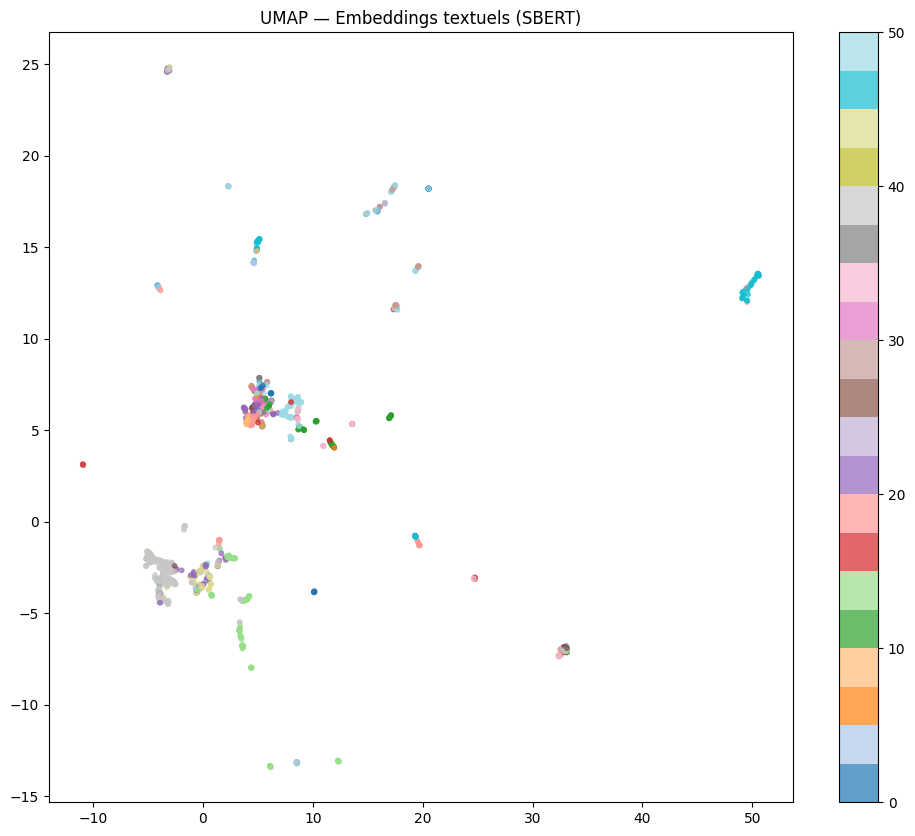

In [104]:

import umap
import matplotlib.pyplot as plt

X_text = np.vstack(data["embedding_sbert"])

reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1)
text_2d = reducer.fit_transform(X_text)

plt.figure(figsize=(12, 10))
plt.scatter(
    text_2d[:,0],
    text_2d[:,1],
    c=data["category2_code"].astype('category').cat.codes,
    cmap="tab20",
    s=10,
    alpha=0.7
)
plt.colorbar()
plt.title("UMAP — Embeddings textuels (SBERT)")
plt.show()


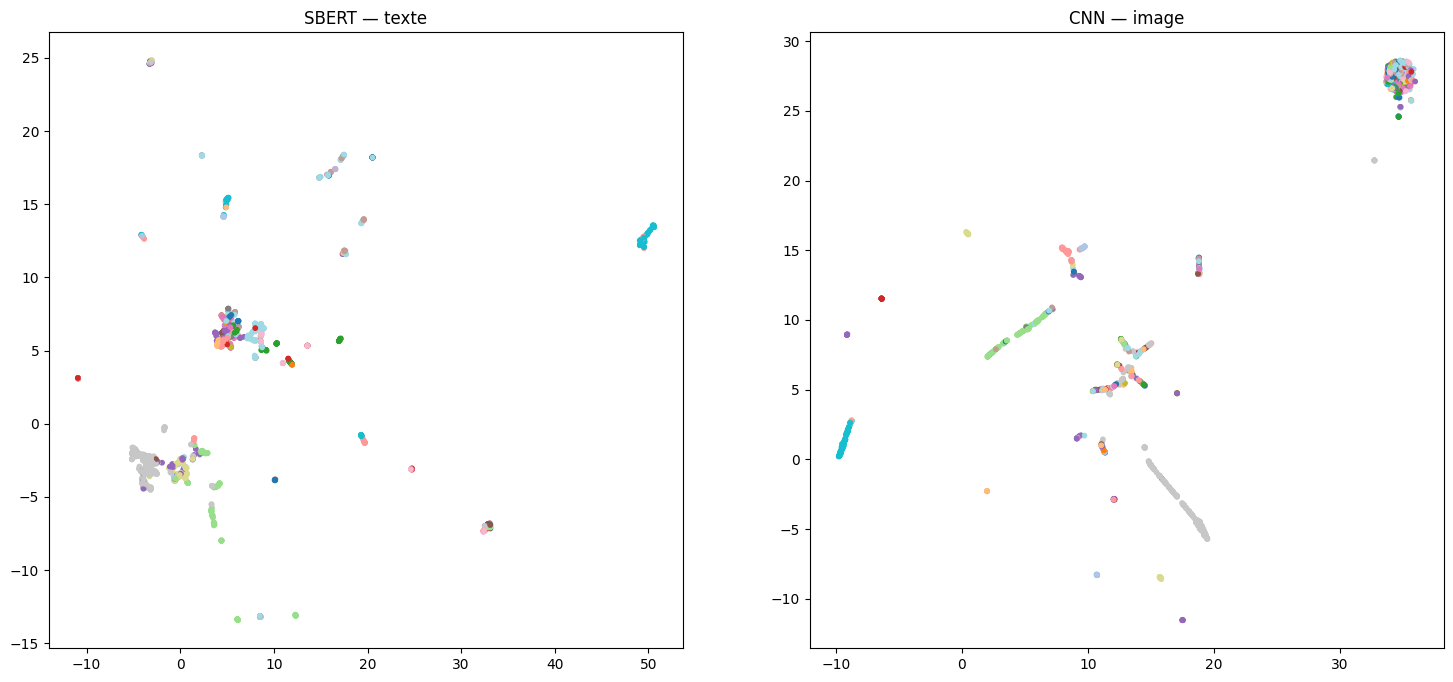

In [105]:
visu_2d = umap.UMAP(n_components=2).fit_transform(X_visu)
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
ax[0].scatter(text_2d[:,0], text_2d[:,1], c=data["category2_code"].astype('category').cat.codes, s=10, cmap="tab20")
ax[0].set_title("SBERT — texte")
ax[1].scatter(visu_2d[:,0], visu_2d[:,1], c=data["category2_code"].astype('category').cat.codes, s=10, cmap="tab20")
ax[1].set_title("CNN — image")
plt.show()

 Les embeddings textuels SBERT produisent des clusters modérément cohérents (ARI = 0.42). L’UMAP montre plusieurs amas compacts reflétant la structure sémantique des titres produits (“Rouge Allure”, “Sublimage”, “Eau de Parfum”), mais aussi une forte superposition due au grand nombre de titres très proches. 
 À l’inverse, les embeddings visuels issus du CNN montrent une structure beaucoup moins organisée (ARI = 0.16). Chanel utilisant une identité visuelle relativement homogène pour ses packagings, les images ne permettent pas de distinguer nettement les catégories. Les clusters reflètent davantage des ressemblances esthétiques (couleurs, textures, formes) que des regroupements fonctionnels.